# Importation des modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import typing as tp

from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score
from xgboost import XGBClassifier

# Variables globales

In [2]:
###### Encodeur ######

encoder: dict = {"Anurofeca_richardsi": 0,
                 "Dermocystidium_salmonis": 1,
                 "Ichthyophonus_hoferi": 2,
                 "Pseudoperkinsus_tapetis": 3,
                 "Psorospermium_haeckelii": 4,
                 "Rhinosporidium_cygnus": 5,
                 "Rhinosporidium_seeberi": 6,
                 "Sphaeroforma_spB7": 7,
                 "Sphaeroforma_spCRG3": 8,
                 "Sphaerothecum_destruens": 9,
                 "unidentified": 10}

###### Encodeur ######


###### Datasets ######

species_amplicons: pd.DataFrame = pd.read_csv(filepath_or_buffer="./dataset/fakes_species_amplicons.csv")
randoms_amplicons: pd.DataFrame = pd.read_csv(filepath_or_buffer="./dataset/fakes_unidentified_amplicons.csv")
test_set: pd.DataFrame = pd.read_csv(filepath_or_buffer="./dataset/Sd_testSet_BC06.csv")
validation_set: pd.DataFrame = pd.read_csv(filepath_or_buffer="./dataset/Sd_testSet_BC12.csv")

###### Datasets ######


###### Paramètres ######

random_state: int = 42
n_iter: int = 100
params: dict =  {"n_estimators": [100, 200, 400, 800],
                 "max_depth": [3, 5, 6, 10, 15, 20, None],
                 "learning_rate": [0.01, 0.1, 0.2, 0.3],
                 "subsample": np.arange(0.1, 1.01, 0.1),
                 "colsample_bytree": np.arange(0.1, 1.01, 0.1),
                 "colsample_bylevel": np.arange(0.1, 1.01, 0.1)}
results: list = [[0 for _ in range(0, len(params.keys()), 1)] for _ in range(0, n_iter, 1)]

###### Paramètres ######

# Fonctions utilitaires

In [3]:
def encode(x: str) -> int :
    
    """ Transforme les labels selon l'encodage défini par le dictionnaire 'encoder'. """
    
    # Initialiser la variable globale 
    global encoder
    
    # Retourner l'encodage de la valeur
    return encoder[x]

In [4]:
def plot_data(X: pd.DataFrame, y: pd.DataFrame, n_sample: int=5000, figsize: tuple=(20, 20), save: str=None, palette: list=["turquoise", "crimson"]) -> None :

    """ Plot les données, à partir d'un TSNE. """
    
    # Effectuer le TSNE
    tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=random_state).fit_transform(X=X.iloc[:n_sample], y=y.iloc[:n_sample])
    tsne = pd.concat(objs=[pd.DataFrame(data=tsne), y.iloc[:n_sample].reset_index(drop=True)], axis=1)
    tsne.columns = ['x', 'y', "specie"]

    # Créer la figure le TSNE
    plt.figure(figsize=figsize)

    # Pour chaque espèce
    for i, specie in enumerate(np.unique(tsne["specie"]).tolist(), start=1) :

        # Plotter l'espèce
        plt.subplot(4, 4, i)
        tmp = tsne["specie"].apply(lambda x: specie if x == specie else -1)
        sns.scatterplot(data=tsne, x='x', y='y', hue=tmp, palette=palette)

    # Sauvegarder la figure
    if save != None :
        plt.savefig(save)

    # Afficher l;a figure
    plt.show()

In [5]:
def plot_cm(y_true: pd.DataFrame, y_pred: pd.DataFrame, figsize: tuple=(14, 8), cmap: str="magma_r", save: str=None) -> None :
    
    """ Plot une matrice de confusion. """

    # Calculer la matrice
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    # Créer la figure
    _, ax = plt.subplots(figsize=figsize)

    # Plotter la matrice
    cm.plot(ax=ax, cmap=cmap)

    # Sauvegarder la figure
    if save != None :
        plt.savefig(save)

    # Afficher la figure
    plt.show()

In [6]:
def plot_classReport(classifier: object, X: pd.DataFrame, y: pd.DataFrame, figsize: tuple=(14, 8), cmap: str="magma_r", save: str=None) -> None :
    
    """ Affiche les résultats de classification d'un modèle. """

    # Effectuer les prédictions sur les données
    y_pred = classifier.predict(X=X)

    # Afficher le rapport de classification
    print(classification_report(y_true=y, y_pred=y_pred, zero_division=0))

    # Afficher la matrice de confusion
    plot_cm(y_true=y, y_pred=y_pred, figsize=figsize, cmap=cmap, save=save)

In [7]:
def plot_learningCurve(classifier: object, sizes: tp.Union[np.array, list]=np.arange(0.1, 1.01, 0.1), figsize: tuple=(14, 10), save: str=None) -> int :

    """ Plot la courbe d'apprentissage d'un modèle ."""

    # Initialiser les variables globales
    global x_train
    global y_train
    global x_test
    global y_test

    # Récupérer le nombre de séquences
    n_sample = len(y_train)
    
    # Initialiser les x
    x_ticks = [0]*len(sizes)

    # Initialiser les y
    scores = [0]*len(sizes)

    # Pour chaque faction
    for i, frac in enumerate(sizes) :

        # Calculer le nombre d'échantillons équivalent à cette fraction
        n = round(n_sample*frac)
        
        # Ajouter le nombre à la liste des x
        x_ticks[i] = n
        
        # Ajouter le recall à la liste des y
        scores[i] = recall_score(y_true=y_test, y_pred=classifier.fit(x_train.iloc[:n], y_train.iloc[:n]).predict(x_test), average="micro")

    # Créer une figure
    plt.figure(figsize=figsize)

    # Plotter la courbe
    plt.plot(x_ticks, scores, color="#111111", label="Score")
    plt.scatter(x_ticks, scores, color="crimson")

    # Paramétrer la figure
    plt.grid()
    plt.xlabel("Train Size")
    plt.ylabel("Recall")
    plt.title("Learning Curve")
    plt.legend(loc="best")

    # Sauvegarder la figure
    if save != None :
        plt.savefig(save)

    # Afficher la figure
    plt.show()

    # Récupérer, et afficher, la meilleure taille d'échantillon
    best_size = sorted(zip(x_ticks, scores), key=lambda x: x[1], reverse=True)[0]
    print(f"Best_size : {best_size}")

    # Retourner la meilleure taille d'échantillon
    return best_size[0]

In [8]:
def plot_features_importances(classifier: object, figsize: tuple=(14, 10), save: str=None, color: str="blue") -> None :
    
    """ Plotter l'importance de chaque features, sous forme d'un barplot. """

    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Plotter la feature_importances, sous forme de barplot
    pd.Series(data=classifier.feature_importances_, index=[i for i in range(0, len(classifier.feature_importances_), 1)]).plot.bar(color=color)

    # Sauvegarder la figure
    if save != None :
        plt.savefig(save)

    # Afficher la figure
    plt.show()

In [9]:
def search_params(size: int) -> list :

    """ Recherche les meilleurs paramètres pour le classifieur. """

    # Initialiser les variables globales
    global params
    global n_iter
    global random_state
    global x_train
    global y_train
    global x_test
    global y_test
    global results

    # Pour le nombre d'itération passé
    for i in range(0, n_iter, 1) :

        # Sélectionner aléatoirement des paramètres
        n_estimator = rd.choice(params["n_estimators"])
        max_depth = rd.choice(params["max_depth"])
        learning_rate = rd.choice(params["learning_rate"])
        subsample = rd.choice(params["subsample"])
        colsample_bytree = rd.choice(params["colsample_bytree"])
        colsample_bylevel = rd.choice(params["colsample_bylevel"])

        # Entrainer le modèle avec les paramètres
        xgb = XGBClassifier(n_estimators=n_estimator,
                            max_depth=max_depth, 
                            learning_rate=learning_rate,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            colsample_bylevel=colsample_bylevel,
                            random_state=random_state).fit(X=x_train.iloc[:size], y=y_train.iloc[:size])

        # Calculer le recall du modèle
        recall = recall_score(y_true=y_test, y_pred=xgb.predict(x_test), average="micro")

        # Ajouter le recall (et les paramètres) à la liste résultat
        results[i] = [n_estimator, max_depth, learning_rate, subsample, colsample_bytree, colsample_bylevel, recall]

    # Récupérer, et afficher, les meilleurs paramètres du modèle
    best_params = sorted(results, key=lambda x: x[6], reverse=True)[0]
    print(f"Best parameters : {best_params}")

    # Retourner les meilleurs paramètres du modèle
    return best_params

# Recherche

In [10]:
# Créer le jeu d'entraînement, avec les séquences simulées
train = pd.concat(objs=[species_amplicons, randoms_amplicons], axis=0).sample(frac=1.0, replace=False, random_state=random_state).reset_index(drop=True)

In [11]:
# Séparer les features et les labels du jeu d'entraînement
x_train, y_train = train.iloc[:, :-1], train.iloc[:, -1].apply(encode)
display(x_train)

# Séparer les features et les labels du jeu de test
x_test, y_test = test_set.iloc[:, :-1], test_set.iloc[:, -1].apply(encode)
display(x_test)

# Séparer les features et les labels du jeu de validation
x_val, y_val = validation_set.iloc[:, :-1], validation_set.iloc[:, -1].apply(encode)
display(x_val)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,4,3,4,4,2,1,1,2,2,3,...,4,3,4,3,1,3,1,3,4,0
1,4,3,4,4,2,1,1,2,2,3,...,1,4,3,4,3,1,3,1,3,4
2,4,3,4,4,2,1,1,2,2,3,...,4,3,1,3,1,3,4,0,0,0
3,4,3,4,4,2,1,1,2,2,3,...,3,4,3,1,3,1,3,4,0,0
4,4,3,4,4,2,1,1,2,2,3,...,3,1,3,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,4,3,4,4,2,1,1,2,2,3,...,4,3,4,3,1,3,1,3,4,0
109996,4,3,4,4,2,1,1,2,2,3,...,1,3,4,0,0,0,0,0,0,0
109997,4,3,4,4,2,1,1,2,2,3,...,3,4,3,1,3,1,3,4,0,0
109998,4,3,4,4,2,1,1,2,2,3,...,3,1,3,4,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,4,3,4,4,2,1,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
1,4,3,4,4,2,1,1,2,2,3,...,4,1,4,2,4,0,0,0,0,0
2,4,3,4,4,2,1,1,2,2,3,...,1,4,2,4,0,0,0,0,0,0
3,4,3,4,4,2,1,1,2,2,3,...,1,4,2,4,0,0,0,0,0,0
4,4,3,4,4,2,1,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29497,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
29498,4,3,4,4,2,1,1,2,2,3,...,2,4,1,4,2,4,0,0,0,0
29499,4,3,4,4,2,1,1,2,2,3,...,2,4,1,4,2,4,0,0,0,0
29500,4,3,4,4,2,1,1,2,2,3,...,4,1,4,2,4,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,4,3,4,4,2,1,1,2,2,3,...,2,4,1,4,2,4,0,0,0,0
1,4,3,4,4,2,1,1,2,2,3,...,4,1,4,2,4,0,0,0,0,0
2,4,3,4,4,2,1,1,2,2,3,...,1,4,2,4,0,0,0,0,0,0
3,4,3,4,4,2,1,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
4,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35237,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
35238,4,3,4,4,2,1,1,2,2,3,...,4,2,4,0,0,0,0,0,0,0
35239,4,3,4,4,2,1,1,2,2,3,...,2,4,0,0,0,0,0,0,0,0
35240,4,3,4,4,2,1,1,2,2,3,...,2,2,4,1,4,2,4,0,0,0


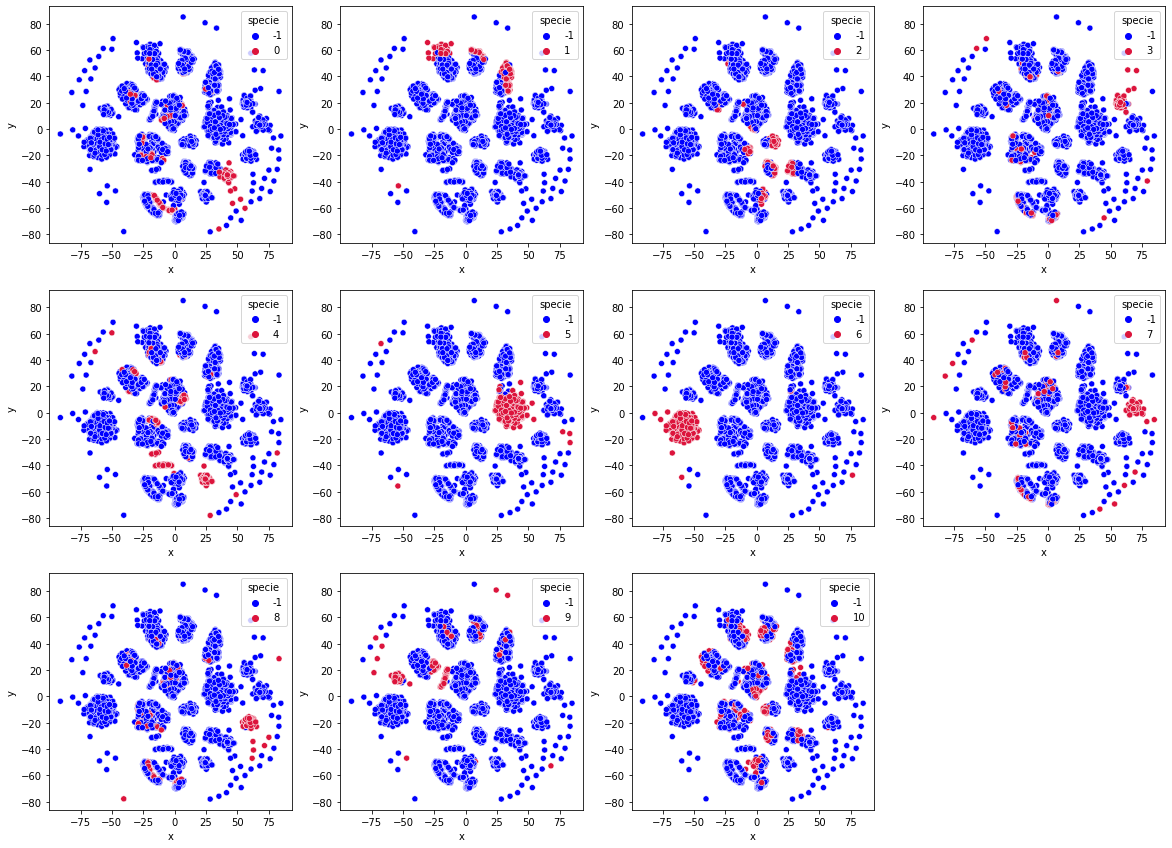

In [12]:
# Plotter le jeu d'entraînement
plot_data(X=x_train, y=y_train, palette=["blue", "crimson"])

In [13]:
# Faire un premier test de la performance du modèle, avec les paramètres de bases, et tout les données d'entraînement
xgb = XGBClassifier(random_state=random_state).fit(X=x_train, y=y_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000
           2       1.00      1.00      1.00     10000
           3       1.00      1.00      1.00     10000
           4       1.00      1.00      1.00     10000
           5       1.00      1.00      1.00     10000
           6       1.00      1.00      1.00     10000
           7       1.00      1.00      1.00     10000
           8       1.00      1.00      1.00     10000
           9       1.00      1.00      1.00     10000
          10       1.00      1.00      1.00     10000

    accuracy                           1.00    110000
   macro avg       1.00      1.00      1.00    110000
weighted avg       1.00      1.00      1.00    110000



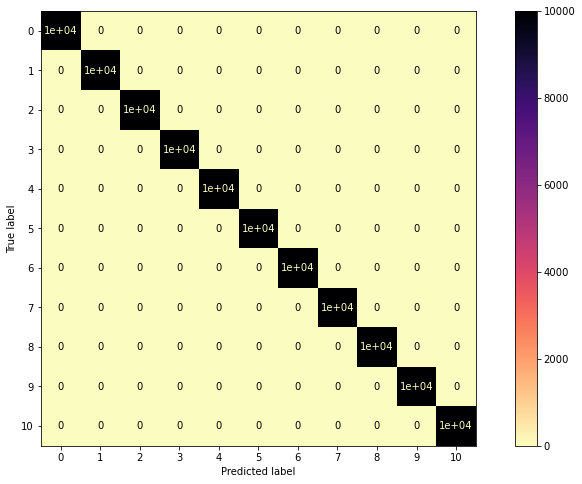

In [14]:
# Plotter les résultats d'entraînement
plot_classReport(classifier=xgb, X=x_train, y=y_train)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.84      0.91     29502
          10       0.00      0.00      0.00         0

    accuracy                           0.84     29502
   macro avg       0.11      0.09      0.10     29502
weighted avg       1.00      0.84      0.91     29502



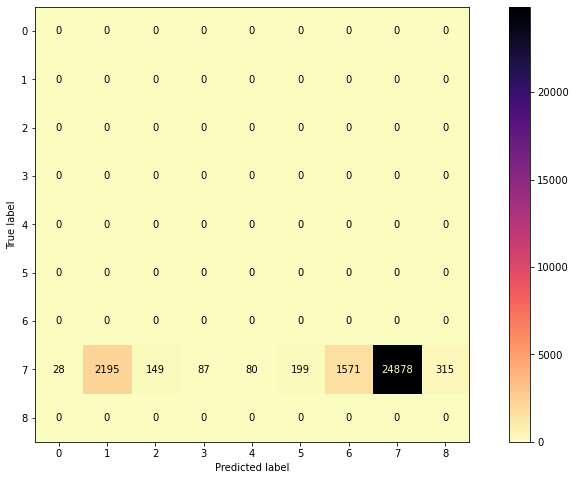

In [15]:
# Plotter les résultat de prédictions sur le test
plot_classReport(classifier=xgb, X=x_test, y=y_test)

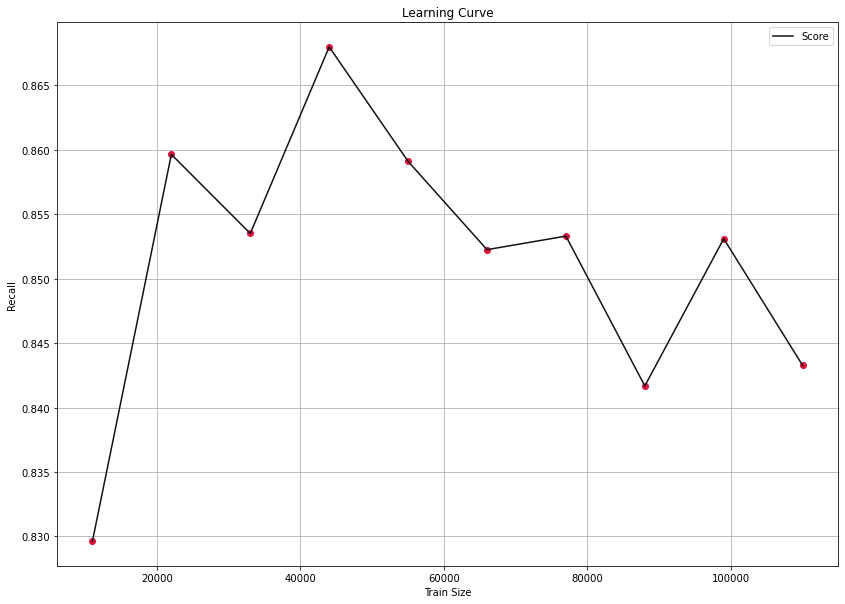

Best_size : (44000, 0.8679750525388109)


In [16]:
# Rechercher la taille optimale du jeu d'entraînement
best_size = plot_learningCurve(classifier=XGBClassifier(random_state=random_state))

In [17]:
# Rechercher les paramètres optimaux du modèle
best_params = search_params(size=best_size)

Best parameters : [400, 3, 0.2, 0.6, 0.6, 0.9, 0.8728221815470137]


In [21]:
# Ré-entraîner le modèle avec les meilleurs paramètres
xgb = XGBClassifier(n_estimators=best_params[0],
                    max_depth=best_params[1],
                    learning_rate=best_params[2],
                    subsample=best_params[3],
                    colsample_bytree=best_params[4],
                    colsample_bylevel=best_params[5],
                    random_state=random_state).fit(X=x_train.iloc[:best_size], y=y_train.iloc[:best_size])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       1.00      0.92      0.96     35242
          10       0.00      0.00      0.00         0

    accuracy                           0.92     35242
   macro avg       0.11      0.10      0.11     35242
weighted avg       1.00      0.92      0.96     35242



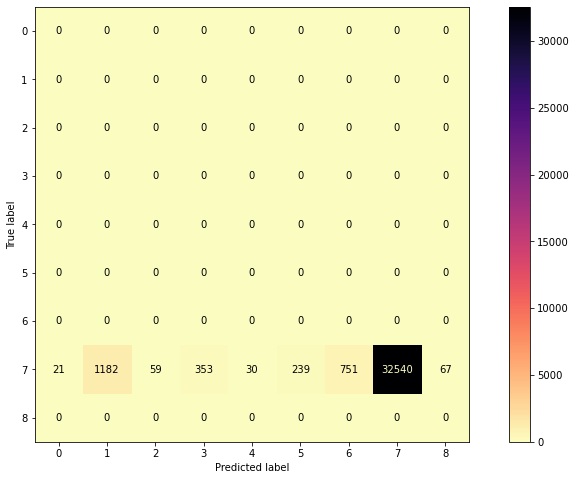

In [22]:
# Plotter les résultat de prédictions sur le validation
plot_classReport(classifier=xgb, X=x_val, y=y_val)

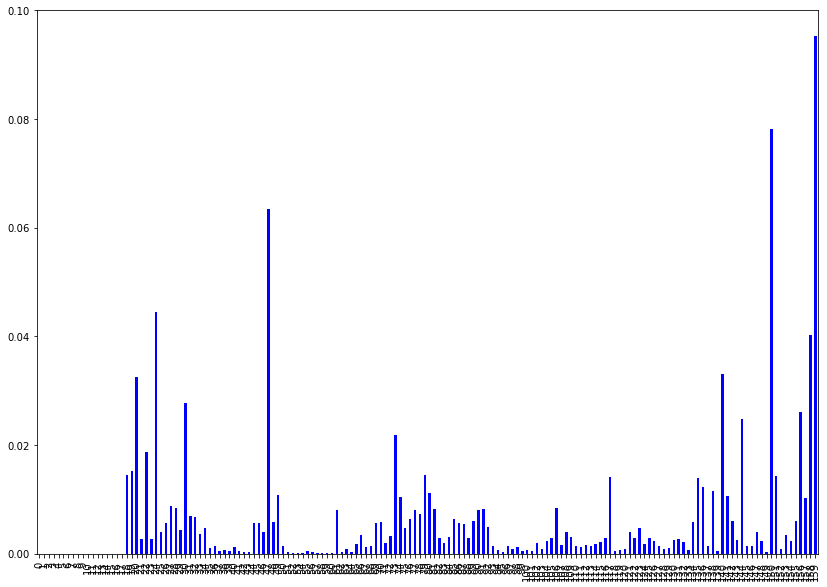

In [23]:
# Plotter l'importance que le modèle attribue à chaque feature
plot_features_importances(classifier=xgb)